In [ ]:
%load_ext autoreload
%autoreload 2
from bliss.encoders.deblend import GalaxyEncoder

import numpy as np
import matplotlib.pyplot as plt 
import torch
from astropy.table import Table
from bliss.datasets.table_utils import column_to_tensor

from astropy.table import Table
from bliss.datasets.lsst import get_default_lsst_psf, get_default_lsst_background
from bliss.datasets.background import add_noise_and_background

import torch
from einops import rearrange, pack, unpack, reduce

from mpl_toolkits.axes_grid1 import make_axes_locatable


# dataset
from bliss.datasets.galsim_blends import generate_dataset, SavedGalsimBlends, parse_dataset


In [ ]:
!echo $CUDA_VISIBLE_DEVICES

5


# Full dataset only bright, but sufficient statistics to check evaluation pipeline

In [ ]:
# smaller dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
cat = catsim_table[ (catsim_table["i_ab"] < 23) & (catsim_table["i_ab"] > 20)]
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
star_mags = all_star_mags[all_star_mags > 20]
psf = get_default_lsst_psf()

n_samples = 100
dataset = generate_dataset(n_samples, cat, star_mags, psf, slen=40, bp=24, max_n_sources=11,galaxy_density=185, star_density=10, max_shift=0.5, add_galaxies_in_padding=True)


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


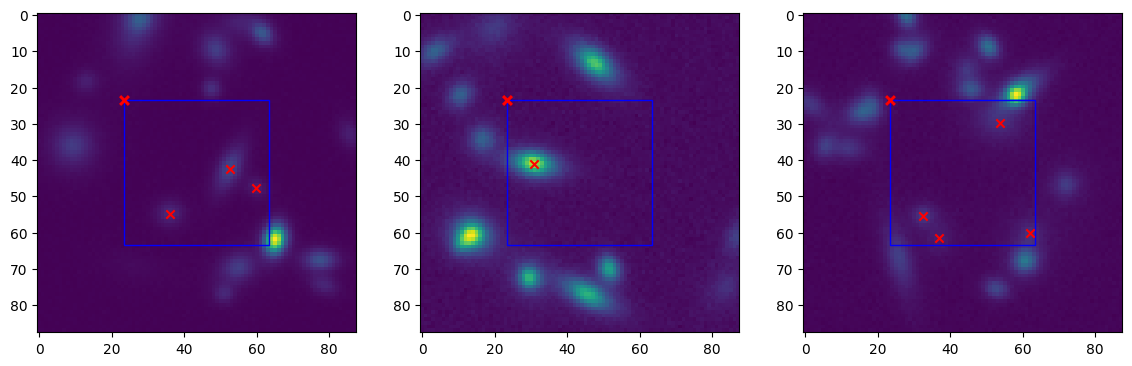

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    rect = patches.Rectangle((43.5-20, 43.5-20), 40, 40, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# setup training datasets
from torch.utils.data import DataLoader
train_ds = {p:q for p,q in dataset.items()}

# now save  data
torch.save(train_ds, "train_ds8.pt")
train_dataset = SavedGalsimBlends("train_ds8.pt", 100, slen=40, keep_padding=True)
train_dl = DataLoader(train_dataset, batch_size = 100, shuffle=True)


In [ ]:

from torch.optim import Adam
from tqdm import tqdm
encoder = GalaxyEncoder('../models/autoencoder.pt')

# gpu 
gpu = torch.device("cuda:0")
encoder.to(gpu)

opt = Adam(encoder.parameters(), lr=1e-2)


for ii in tqdm(range(1000), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat, paddings = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        paddings = paddings.to(gpu)
        loss = encoder.get_loss(images, paddings, background, truth_cat)
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        train_n_batches+=1 

    running_loss /= train_n_batches

    if ii % 50 == 49:

        print('epoch:', ii, ',training_loss: ', running_loss)

epoch::   5%|▌         | 52/1000 [00:05<01:15, 12.56it/s]

epoch: 49 ,training_loss:  6650238.5


epoch::  10%|█         | 102/1000 [00:09<01:03, 14.08it/s]

epoch: 99 ,training_loss:  6111170.0


epoch::  15%|█▌        | 152/1000 [00:14<01:16, 11.02it/s]

epoch: 149 ,training_loss:  5992959.0


epoch::  20%|██        | 202/1000 [00:18<00:59, 13.50it/s]

epoch: 199 ,training_loss:  5901962.5


epoch::  25%|██▌       | 250/1000 [00:22<00:53, 14.07it/s]

epoch: 249 ,training_loss:  5874373.5


epoch::  30%|███       | 300/1000 [00:26<01:01, 11.44it/s]

epoch: 299 ,training_loss:  5862014.5


epoch::  35%|███▌      | 352/1000 [00:30<00:53, 12.21it/s]

epoch: 349 ,training_loss:  5861869.5


epoch::  40%|████      | 402/1000 [00:34<00:43, 13.79it/s]

epoch: 399 ,training_loss:  5846923.0


epoch::  45%|████▌     | 450/1000 [00:38<00:38, 14.14it/s]

epoch: 449 ,training_loss:  5847335.5


epoch::  50%|█████     | 502/1000 [00:43<00:48, 10.20it/s]

epoch: 499 ,training_loss:  5851152.0


epoch::  55%|█████▌    | 552/1000 [00:47<00:34, 12.96it/s]

epoch: 549 ,training_loss:  5840355.0


epoch::  60%|██████    | 602/1000 [00:51<00:28, 14.21it/s]

epoch: 599 ,training_loss:  5838602.0


epoch::  65%|██████▌   | 650/1000 [00:55<00:36,  9.57it/s]

epoch: 649 ,training_loss:  5837671.5


epoch::  70%|███████   | 702/1000 [01:00<00:22, 13.06it/s]

epoch: 699 ,training_loss:  5843198.0


epoch::  75%|███████▌  | 752/1000 [01:04<00:17, 14.01it/s]

epoch: 749 ,training_loss:  5885258.0


epoch::  80%|████████  | 800/1000 [01:08<00:18, 10.97it/s]

epoch: 799 ,training_loss:  5835946.0


epoch::  85%|████████▌ | 852/1000 [01:12<00:12, 11.80it/s]

epoch: 849 ,training_loss:  5836702.0


epoch::  90%|█████████ | 902/1000 [01:16<00:07, 13.65it/s]

epoch: 899 ,training_loss:  5834187.0


epoch::  95%|█████████▌| 950/1000 [01:20<00:03, 14.15it/s]

epoch: 949 ,training_loss:  5836866.0


epoch:: 100%|██████████| 1000/1000 [01:25<00:00, 11.74it/s]

epoch: 999 ,training_loss:  5832916.0


In [ ]:
# use for evaluation 
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange, repeat
from matplotlib.figure import Figure
from torch import Tensor
from tqdm import tqdm
from copy import deepcopy

from bliss.catalog import FullCatalog, TileCatalog
from bliss.datasets.lsst import PIXEL_SCALE, get_default_lsst_psf_tensor
from bliss.encoders.autoencoder import CenteredGalaxyDecoder
from bliss.encoders.encoder import Encoder
from bliss.plotting import BlissFigure, scatter_shade_plot
from bliss.reporting import (
    compute_bin_metrics,
    get_blendedness,
    get_boostrap_precision_and_recall,
    get_single_galaxy_measurements,
    match_by_locs,
)
from bliss.render_tiles import reconstruct_image_from_ptiles, render_galaxy_ptiles

def evaluation_pipeline(data_file:str, decoder:CenteredGalaxyDecoder, bp:int,
                         encoder:Encoder=None, galaxy_encoder:GalaxyEncoder=None
                         ):
    assert encoder is None or galaxy_encoder is None
    assert galaxy_encoder is not None or encoder is not None

    # if encoder is provided, assume full trained models
    # if galaxy_encoder is provided, assume only using galaxy_encoder is trained and give it true positions/booleans 
    blend_data: dict[str, Tensor] = torch.load(data_file)

    images = blend_data.pop("images").float()
    background = blend_data.pop("background").float()
    uncentered_sources = blend_data.pop("uncentered_sources").float()
    centered_sources = blend_data.pop("centered_sources").float()
    paddings = blend_data.pop("paddings")

    blend_data.pop("noiseless")

    n_batches, _, size, _ = images.shape # same size as `*_sources`
    assert background.shape == images.shape
    psf_tensor = get_default_lsst_psf_tensor(size)


    # obtain `FullCatalog` from saved data
    slen = size - 2 * bp
    truth = FullCatalog(slen, slen, blend_data)
    truth_tile_catalog = truth.to_tile_params(4, ignore_extra_sources=True)


    # get additional truth information needed
    b, ms1, _ = truth.plocs.shape
    assert centered_sources.shape == (b, ms1, 1, size, size)
    assert uncentered_sources.shape == (b, ms1, 1, size, size)
    flat_indiv = rearrange(centered_sources, "b ms c h w -> (b ms) c h w")
    flat_bg1 = repeat(background, "b c h w -> (b ms) c h w", ms=ms1, h=size, w=size)
    tflux, tsnr, tellip = get_single_galaxy_measurements(
        flat_indiv, flat_bg1, psf_tensor, PIXEL_SCALE, no_bar=False
    )
    truth["galaxy_fluxes"] = rearrange(tflux, "(b ms) -> b ms 1", ms=ms1)
    truth["snr"] = rearrange(tsnr, "(b ms) -> b ms 1", ms=ms1)
    truth["ellips"] = rearrange(tellip, "(b ms) g -> b ms g", ms=ms1, g=2)
    blendedness = get_blendedness(uncentered_sources)
    assert not blendedness.isnan().any()
    truth["blendedness"] = rearrange(blendedness, "b ms -> b ms 1", b=b, ms=ms1)

    with torch.no_grad():
        # get additional galaxy quantities from predicted information
        if encoder is not None:
            tile_est = encoder.variational_mode(images, background).to(torch.device("cpu"))
            est = tile_est.to_full_params() 
        
        else:
            # use true parameters for everything except galaxy ones
            est_galaxy_params = galaxy_encoder.variational_mode(images, background, truth_tile_catalog)
            tile_est = TileCatalog(4, truth_tile_catalog.to_dict())
            tile_est["galaxy_params"] = est_galaxy_params
            est = tile_est.to_full_params()

    flat_galaxy_params = rearrange(est["galaxy_params"], "b ms d -> (b ms) d", d=8)
    flat_galaxy_bools = rearrange(est["galaxy_bools"], "b ms 1 -> (b ms) 1")

    # not sure if batches are necessary here
    psf_tensor2 = get_default_lsst_psf_tensor(decoder.slen)
    b, ms2, _ = est["galaxy_params"].shape
    n_total = b * ms2
    flat_bg2 = repeat(
        torch.tensor([background[0, 0, 0, 0].item()]),
        "() -> (b ms) c h w",
        b=b,
        ms=ms2,
        c=1,
        h=decoder.slen,
        w=decoder.slen,
    )

    # get ellipticities, fluxes and SNR
    egals_raw = decoder(flat_galaxy_params).cpu()
    egals = egals_raw * rearrange(flat_galaxy_bools, "npt 1 -> npt 1 1 1")
    eflux, esnr, eellips = get_single_galaxy_measurements(
        egals, flat_bg2, psf_tensor2
    )

    # finally put into TileCatalog and get FullCatalog
    est["fluxes"] = rearrange(eflux, "(b ms) -> b ms 1", b=b, ms=ms2)
    est["snr"] = rearrange(esnr, "(b ms) -> b ms 1", b=b, ms=ms2)
    est["ellips"] = rearrange(eellips, "(b ms) g -> b ms g", b=b, ms=ms2, g=2)

    # in addition compute predicted images for checking quality of residuals
    with torch.no_grad():
        galaxies = render_galaxy_ptiles(decoder, tile_est.locs,
                                        tile_est['galaxy_params'], tile_est['galaxy_bools'], 
                                        52, 4)
        pred_images = reconstruct_image_from_ptiles(galaxies, 4) + background.mean()

    # collect quantities for residuals on ellipticites and flux of galaxies
    snr = []
    blendedness = []
    true_fluxes = []
    true_ellips1 = []
    true_ellips2 = []
    est_fluxes = []
    est_ellips1 = []
    est_ellips2 = []

    for ii in tqdm(range(n_batches), desc="Matching batches"):
        true_plocs_ii, est_plocs_ii = truth.plocs[ii], est.plocs[ii]
        tindx, eindx, dkeep, _ = match_by_locs(true_plocs_ii, est_plocs_ii)
        n_matches = len(tindx[dkeep])

        if n_matches > 0:
            # only evaluate flux/ellipticity residuals on galaxies labelled as galaxies.
            tgbool_ii = truth["galaxy_bools"][ii][tindx][dkeep]
            egbool_ii = est["galaxy_bools"][ii][eindx][dkeep]
            gbool_ii = torch.eq(tgbool_ii, egbool_ii).eq(torch.ones_like(tgbool_ii))
            gbool_ii = gbool_ii.flatten()
            snr_ii_class = truth["snr"][ii][tindx][dkeep]

            assert len(tgbool_ii) == len(egbool_ii) == len(snr_ii_class) == n_matches

            snr_ii = truth["snr"][ii][tindx][dkeep][gbool_ii]  # noqa: WPS219
            blendedness_ii = truth["blendedness"][ii][tindx][dkeep][gbool_ii]  # noqa: WPS219
            true_flux_ii = truth["fluxes"][ii][tindx][dkeep][gbool_ii]  # noqa: WPS219
            est_flux_ii = est["fluxes"][ii][eindx][dkeep][gbool_ii]  # noqa: WPS219
            true_ellips_ii = truth["ellips"][ii][tindx][dkeep][gbool_ii]  # noqa: WPS219
            est_ellips_ii = est["ellips"][ii][eindx][dkeep][gbool_ii]  # noqa: WPS219

            n_matched_gals = len(snr_ii)

            for jj in range(n_matched_gals):
                snr.append(snr_ii[jj].item())
                blendedness.append(blendedness_ii[jj].item())
                true_ellips1.append(true_ellips_ii[jj][0].item())
                true_ellips2.append(true_ellips_ii[jj][1].item())
                est_ellips1.append(est_ellips_ii[jj][0].item())
                est_ellips2.append(est_ellips_ii[jj][1].item())
                true_fluxes.append(true_flux_ii[jj].item())
                est_fluxes.append(est_flux_ii[jj].item())

    true_ellips = torch.vstack([torch.tensor(true_ellips1), torch.tensor(true_ellips2)])
    true_ellips = true_ellips.T.reshape(-1, 2)

    est_ellips = torch.vstack([torch.tensor(est_ellips1), torch.tensor(est_ellips2)])
    est_ellips = est_ellips.T.reshape(-1, 2)

    true_fluxes = torch.tensor(true_fluxes)
    est_fluxes = torch.tensor(est_fluxes)
    snr = torch.tensor(snr)
    blendedness = torch.tensor(blendedness)


    return {
        'true': {
            'flux': true_fluxes,
            'g1': true_ellips1,
            'g2': true_ellips2,
            'images': images,
            'full_cat': truth,
        },
        'pred': {
            'flux': est_fluxes,
            'g1': est_ellips1,
            'g2': est_ellips2,
            'images': pred_images,
            'full_cat': est,
        },
        'snr': snr,
        'bld': blendedness,
        'paddings': paddings,
    }


In [ ]:
# first check if we use true locations and booleans what are residuals and scatter plots like

model_cpu = encoder.to(torch.device("cpu"))
model_cpu.eval()
results1 = evaluation_pipeline('train_ds8.pt', model_cpu._dec, 24, galaxy_encoder=model_cpu)

images = results1['true']['images']
pred_images = results1['pred']['images']
truth = results1['true']['full_cat']
paddings = results1['paddings']


# compare both galaxies side by side
fig, axes = plt.subplots(20, 3, figsize=(8, 40))
for ii, (ax1, ax2, ax3) in enumerate(axes):
    im1 = ax1.imshow(images[ii, 0])
    im2 = ax2.imshow(pred_images[ii, 0])
    im3 = ax3.imshow( (pred_images[ii, 0] - images[ii, 0] + paddings[ii, 0]) /  pred_images[ii,0].sqrt() )

    for im, ax in zip((im1,im2,im3), (ax1,ax2,ax3)):
        divider = make_axes_locatable(ax)
        cax =  divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    
    n_sources = truth.n_sources[ii]
    plocs = truth.plocs[ii]
    galaxy_bools = truth['galaxy_bools'][ii]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24
    for jj in range(n_sources):
        if galaxy_bools[jj] > 0: 
            ax1.scatter(x[jj], y[jj], marker='x', color='r', s=24)
        else: 
            ax1.scatter(x[jj], y[jj], marker='x', color='b', s=24)

plt.tight_layout()
_ = fig.savefig('residuals8.pdf');
plt.close(fig)

Matching batches: 100%|██████████| 100/100 [00:00<00:00, 828.04it/s]


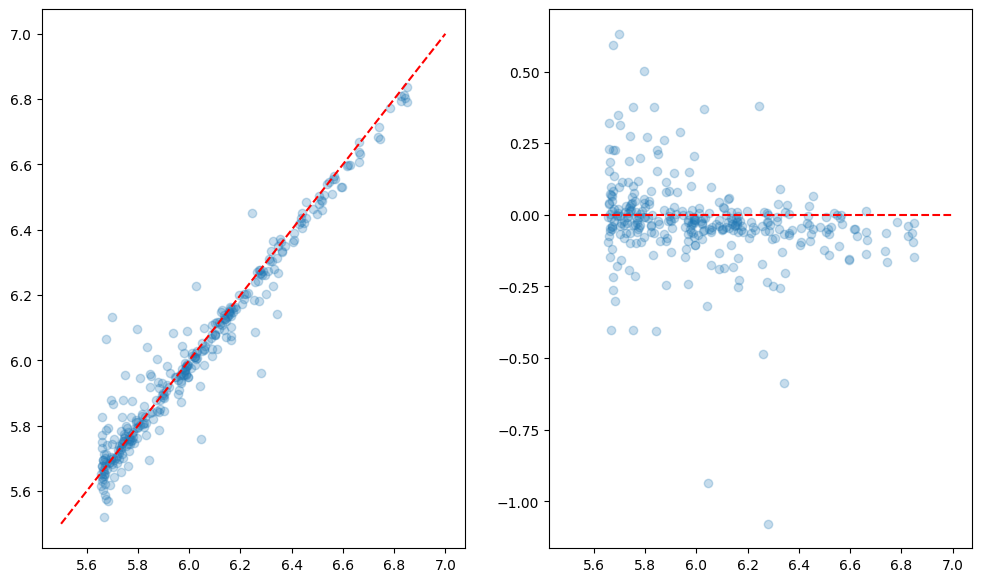

In [ ]:
flux1 = results1['true']['flux']
flux2 = results1['pred']['flux']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))

ax1.scatter(flux1.log10(), flux2.log10(), alpha=0.25)
ax1.plot([5.5, 7], [5.5, 7], linestyle='--', color='r')

ax2.scatter(flux1.log10(), (flux2 - flux1) / flux2, alpha=0.25)
ax2.plot([5.5, 7], [0, 0], linestyle='--', color='r')

(0.0, 0.5)

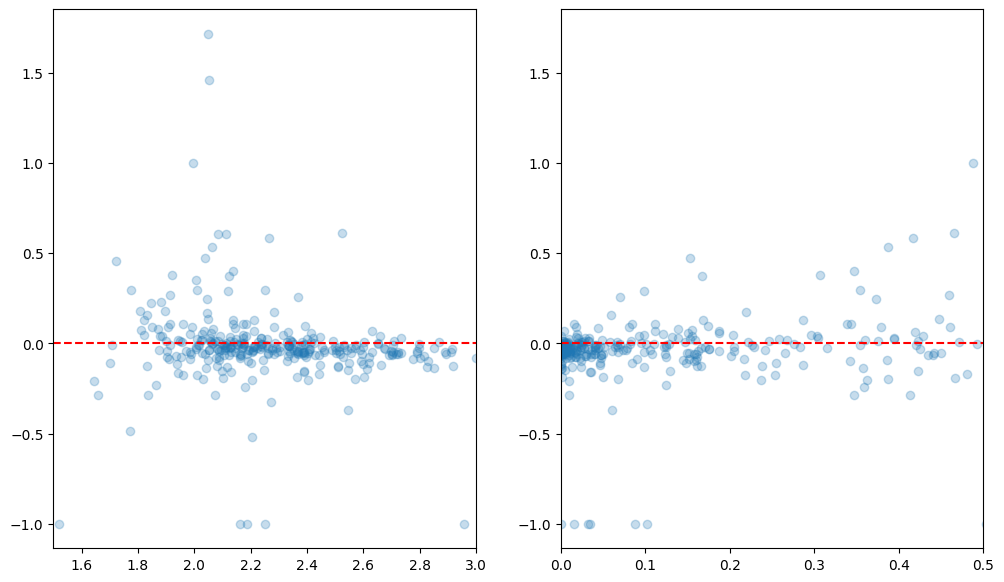

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))

flux1 = results1['true']['flux']
flux2 = results1['pred']['flux']
snr = results1['snr']
bld = results1['bld']

ax1.scatter(snr.log10(), (flux2 - flux1) / flux1, alpha=0.25)
ax1.plot([1.5, 3], [0, 0], linestyle='--', color='r')
ax1.set_xlim(1.5, 3)


ax2.scatter(bld, (flux2 - flux1) / flux1, alpha=0.25)
ax2.plot([0, 0.5], [0, 0], linestyle='--', color='r')
ax2.set_xlim(0, 0.5)

In [ ]:
# now we run the full pipeline , using the pre-trained binary and 
# detection models that we have saved

# load detection encoder with pre-trained weights
from bliss.encoders.detection import DetectionEncoder
detection = DetectionEncoder().to(torch.device("cpu")).eval()
detection.load_state_dict(torch.load("../models/detection.pt", map_location=torch.device("cpu")))
detection.requires_grad_(False)

from bliss.encoders.binary import BinaryEncoder
binary = BinaryEncoder().to(torch.device("cpu")).eval()
binary.load_state_dict(torch.load("../models/binary.pt", map_location=torch.device("cpu")))
binary.requires_grad_(False)

from bliss.encoders.encoder import Encoder
enc = Encoder(
    detection.eval(),
    binary.eval(),
    model_cpu.eval(),
    n_images_per_batch=20,
    n_rows_per_batch=30,
)
enc = enc.to(torch.device("cpu"))

In [ ]:
model_cpu = encoder.to(torch.device("cpu"))
model_cpu.eval()
results2 = evaluation_pipeline('train_ds8.pt', model_cpu._dec, 24, encoder=enc)

images = results2['true']['images']
pred_images = results2['pred']['images']
truth = results2['true']['full_cat']
paddings = results2['paddings']


In [ ]:
# compare both galaxies side by side
#conclusion: inconclusive at best :') 
fig, axes = plt.subplots(20, 3, figsize=(8, 40))
for ii, (ax1, ax2, ax3) in enumerate(axes):
    im1 = ax1.imshow(images[ii, 0])
    im2 = ax2.imshow(pred_images[ii, 0])
    im3 = ax3.imshow( (pred_images[ii, 0] - images[ii, 0] + paddings[ii, 0]) /  pred_images[ii,0].sqrt(), vmin=-5, vmax=5 )

    for im, ax in zip((im1,im2,im3), (ax1,ax2,ax3)):
        divider = make_axes_locatable(ax)
        cax =  divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    
    n_sources = truth.n_sources[ii]
    plocs = truth.plocs[ii]
    galaxy_bools = truth['galaxy_bools'][ii]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24
    for jj in range(n_sources):
        if galaxy_bools[jj] > 0: 
            ax1.scatter(x[jj], y[jj], marker='x', color='r', s=24)
        else: 
            ax1.scatter(x[jj], y[jj], marker='x', color='b', s=24)

    n_sources = est.n_sources[ii]
    plocs = est.plocs[ii]
    galaxy_bools = est['galaxy_bools'][ii]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24
    for jj in range(n_sources):
        if galaxy_bools[jj] > 0: 
            ax2.scatter(x[jj], y[jj], marker='x', color='r', s=24)
        else: 
            ax2.scatter(x[jj], y[jj], marker='x', color='b', s=24)

plt.tight_layout()
_ = fig.savefig('residuals8-2.pdf');
plt.close(fig)

Matching batches: 100%|██████████| 100/100 [00:00<00:00, 962.40it/s]


In [ ]:
import torch
true_fluxes = torch.tensor(true_fluxes)


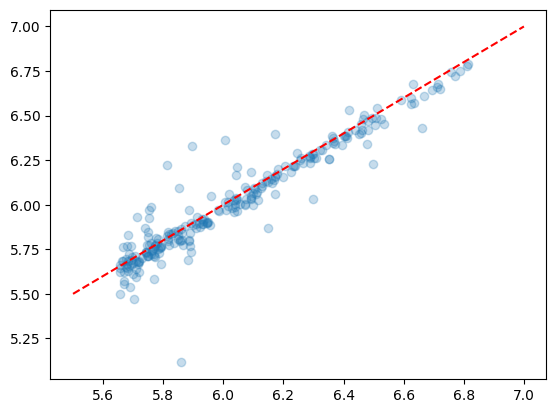

In [ ]:
plt.scatter(true_fluxes.log10(), est_fluxes.log10(), alpha=0.25)
plt.plot([5.5, 7], [5.5, 7], linestyle='--', color='r')

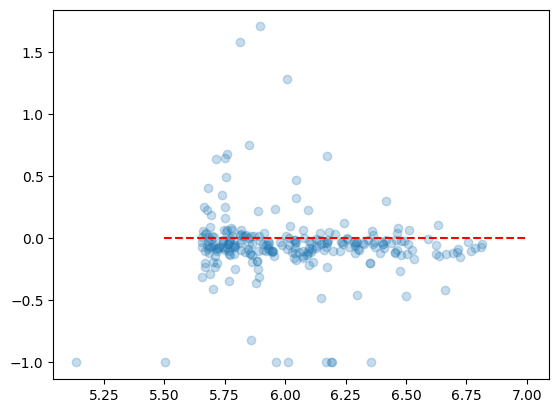

In [ ]:
plt.scatter(true_fluxes.log10(), (est_fluxes - true_fluxes) / true_fluxes, alpha=0.25)
plt.plot([5.5, 7], [0, 0], linestyle='--', color='r')

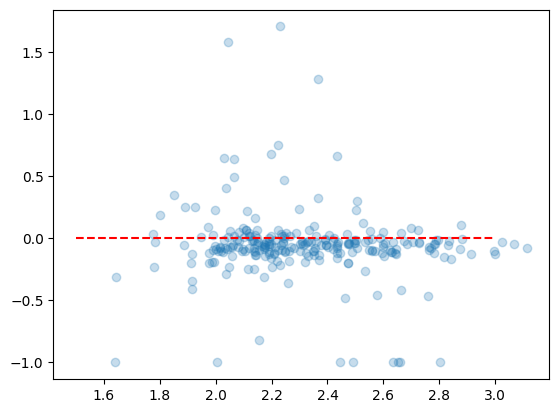

In [ ]:
plt.scatter(snr.log10(), (est_fluxes - true_fluxes) / true_fluxes, alpha=0.25)
plt.plot([1.5, 3], [0, 0], linestyle='--', color='r')

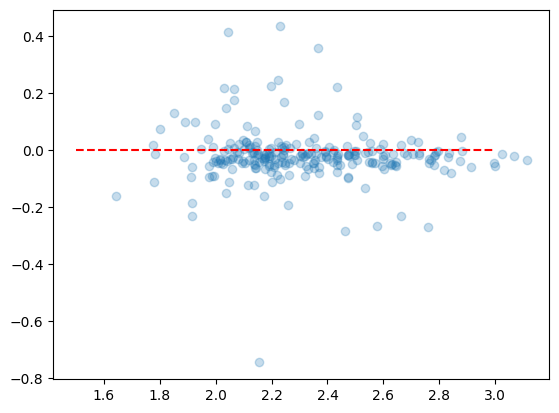

: 

In [ ]:
plt.scatter(snr.log10(), est_fluxes.log10() - true_fluxes.log10(), alpha=0.25)
plt.plot([1.5, 3], [0, 0], linestyle='--', color='r')

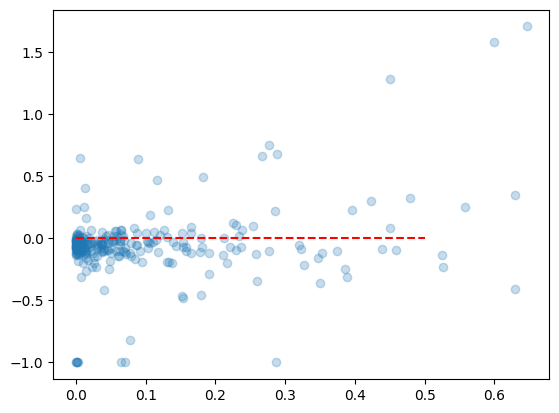

In [ ]:
plt.scatter(blendedness, (est_fluxes - true_fluxes) / true_fluxes, alpha=0.25)
plt.plot([0, 0.5], [0, 0], linestyle='--', color='r')

/home/imendoza/bliss/bliss/plotting.py:246: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_bin: np.ndarray = y[keep_x]


(-0.5, 0.5)

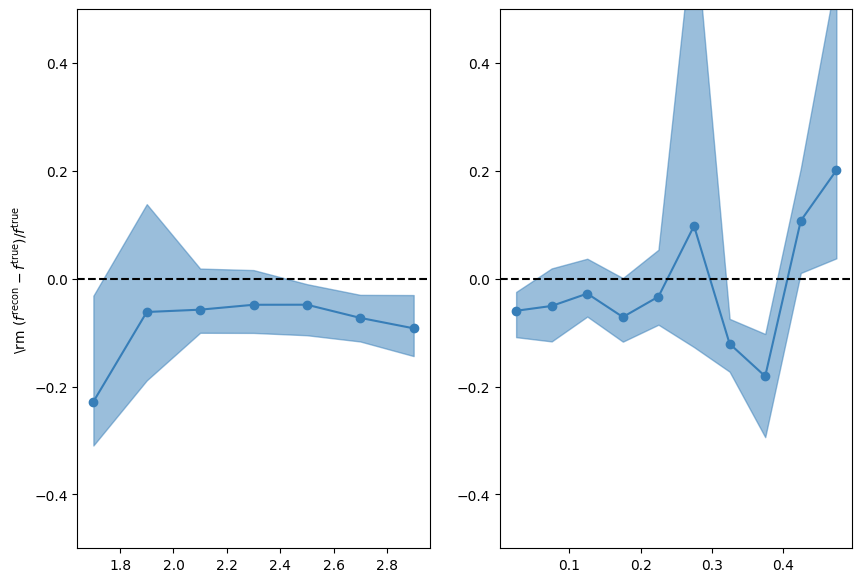

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))

xlims = (1.6, 3)
xlabel = r"$\log_{10} \rm SNR$"
ylabel = r"\rm $(f^{\rm recon} - f^{\rm true}) / f^{\rm true}$"
x, y = np.log10(snr), (est_fluxes - true_fluxes) / true_fluxes
scatter_shade_plot(ax1, x, y, xlims, delta=0.2)
ax1.set_ylabel(ylabel)
ax1.axhline(0, ls="--", color="k")
ax1.set_ylim(-0.5, 0.5)

xlims = (0, 0.5)
x, y = blendedness, (est_fluxes - true_fluxes) / true_fluxes
scatter_shade_plot(ax2, x, y, xlims, delta=0.05)
ax2.axhline(0, ls="--", color="k")
ax2.set_ylim(-0.5, 0.5)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,  26., 131.,  81.,  10.,
          0.,   0.,   0.]),
 array([-10.        ,  -9.49301243,  -8.98602486,  -8.47903824,
         -7.97205019,  -7.4650631 ,  -6.95807552,  -6.45108843,
         -5.94410086,  -5.43711329,  -4.93012619,  -4.42313862,
         -3.91615129,  -3.40916371,  -2.90217638,  -2.39518905,
         -1.88820159,  -1.38121414,  -0.87422681,  -0.36723939,
          0.13974801,   0.64673543,   1.15372276,   1.66071022,
          2.16769767,   2.674685  ]),
 [<matplotlib.patches.Polygon at 0x7f8cc440fee0>])

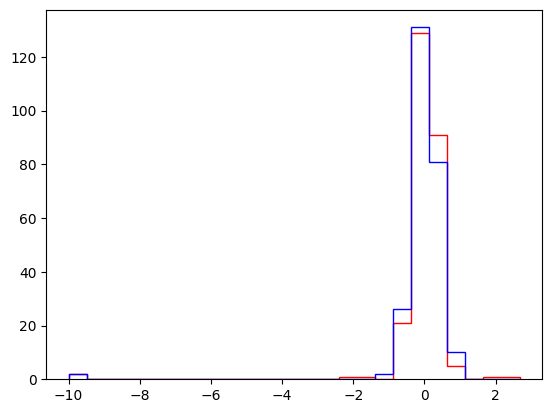

In [ ]:
_, bins, _ = plt.hist(est_ellips[:, 0], histtype='step', color='r', bins=25)
plt.hist(true_ellips[:, 0], histtype='step', color='b', bins=bins)

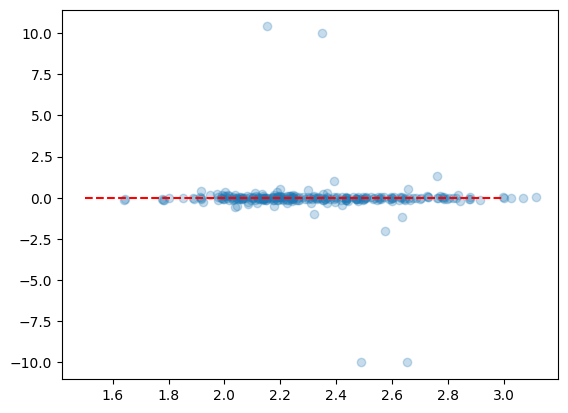

In [ ]:
plt.scatter(snr.log10(), true_ellips[:, 0] - est_ellips[:, 0], alpha=0.25)
plt.plot([1.5, 3], [0, 0], linestyle='--', color='r')

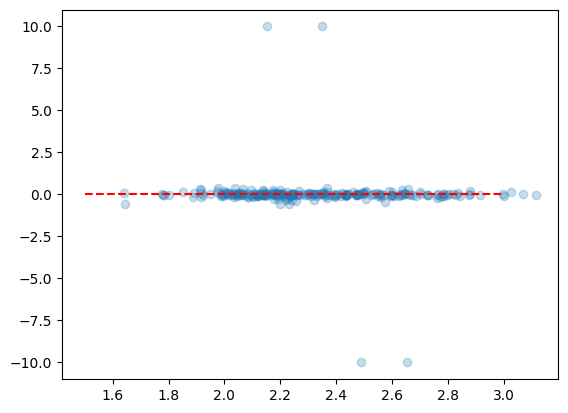

In [ ]:
plt.scatter(snr.log10(), true_ellips[:, 1] - est_ellips[:, 1], alpha=0.25)
plt.plot([1.5, 3], [0, 0], linestyle='--', color='r')

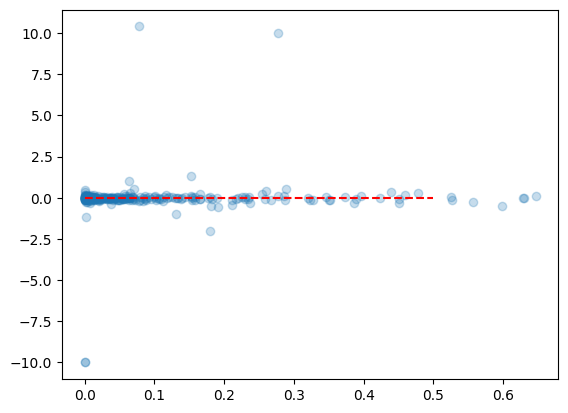

In [ ]:
plt.scatter(blendedness, true_ellips[:, 0] - est_ellips[:, 0], alpha=0.25)
plt.plot([0, 0.5], [0, 0], linestyle='--', color='r')

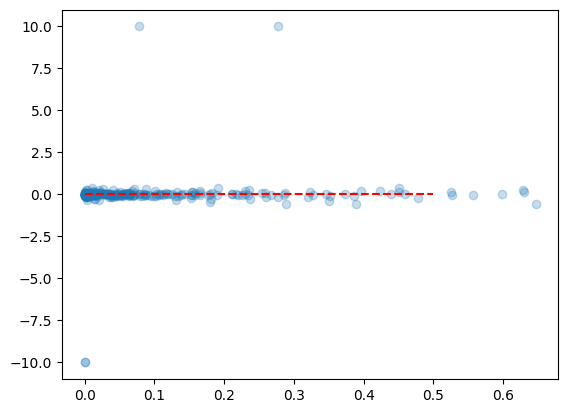

In [ ]:
plt.scatter(blendedness, true_ellips[:, 1] - est_ellips[:, 1], alpha=0.25)
plt.plot([0, 0.5], [0, 0], linestyle='--', color='r')